---
format:
    html:
        embed-resources: true
---

# Analyzing Renewable Energy Trends in India: A Comparative Study of LSTM and Machine Learning

# Problem Definition

This project aimed to forecast daily wind and hydroelectric power generation in India using historical data. The objectives were to:
Model Renewable Energy Generation: Build predictive models for daily wind and hydro generation to better understand the trends.


This is important because:
Energy Security and Climate Goals: Accurate predictions reduce dependence on non-renewables, contributing to energy independence and carbon emission reductions.
Cost Efficiency and Economic Growth: Better planning minimizes energy waste, reduces costs, and supports industrial and rural electrification.

## India Map

In [2]:
import geopandas as gpd
import folium

# Load the shapefile for India
shapefile_path = "ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp"
world = gpd.read_file(shapefile_path)
india = world[world['NAME'] == 'India']  # Filter the shapefile to include only India

# Convert the GeoDataFrame to GeoJSON format
india_geojson = india.to_json()

# Create an interactive map centered on India
india_map = folium.Map(location=[22.3511148, 78.6677428], zoom_start=5)

# Add the GeoJSON layer to the map
folium.GeoJson(
    india_geojson,
    name='India',
    tooltip=folium.GeoJsonTooltip(fields=['NAME'], aliases=['State:'])  # Show the name of states on hover
).add_to(india_map)

# Save the interactive map as an HTML file
india_map.save("interactive_india_map.html")
print("Interactive map saved as 'interactive_india_map.html'")

# Display the map in a Jupyter Notebook 
from IPython.display import IFrame
IFrame('interactive_india_map.html', width=800, height=600)

Interactive map saved as 'interactive_india_map.html'


# Data Collection and Refinement

Data Source: The dataset was sourced from Kaggle, titled Daily Power Generation in India [2013-2023]. It includes daily power generation records for multiple energy sources (wind, hydro, coal, etc.) across various Indian regions.

Data Refinement Steps:
Missing Value Handling: Missing values in numeric columns were filled using median values to maintain consistency.

Date Formatting: The date column was converted to a datetime format for time series analysis.

Feature Selection: Data for wind and hydro generation were filtered to focus on these renewable sources.

Normalization: Consistency was ensured across the dataset to prepare it for modeling.

## Data Cleaning

In [3]:
import pandas as pd

# Load data
data_source = pd.read_csv("data/Daily_Power_Gen_Source_march_23.csv")
data_states = pd.read_csv("data/Daily_Power_Gen_States_march_23.csv")

# Check for missing values
print("Dataset 1 (Source) missing values:")
print(data_source.isnull().sum())
print("\nDataset 2 (States) missing values:")
print(data_states.isnull().sum())

# Fill or remove empty values
numeric_cols_source = data_source.select_dtypes(include=["float64", "int64"]).columns
numeric_cols_states = data_states.select_dtypes(include=["float64", "int64"]).columns

# Fill missing values with median instead of mean
for col in numeric_cols_source:
    if data_source[col].isnull().sum() > 0:
        print(f"Filling missing values in {col} with median.")
        data_source[col] = data_source[col].fillna(data_source[col].median())

for col in numeric_cols_states:
    if data_states[col].isnull().sum() > 0:
        print(f"Filling missing values in {col} with median.")
        data_states[col] = data_states[col].fillna(data_states[col].median())

# Check if any non-numeric values exist in numeric columns
for col in numeric_cols_states:
    invalid_values = data_states[~data_states[col].apply(lambda x: isinstance(x, (int, float)))]
    if not invalid_values.empty:
        print(f"Non-numeric values found in {col}:")
        print(invalid_values)
        data_states[col] = pd.to_numeric(data_states[col], errors='coerce')

# Drop remaining rows with null values
data_source = data_source.dropna()
data_states = data_states.dropna()

# Check date column and ensure proper formatting
data_source["date"] = pd.to_datetime(data_source["date"], errors="coerce")
data_states["date"] = pd.to_datetime(data_states["date"], errors="coerce")

# Remove invalid dates
data_source = data_source.dropna(subset=["date"])
data_states = data_states.dropna(subset=["date"])

# Recheck the cleaned data
print("\nCleaned Dataset 1 (Source):")
print(data_source.describe(include='all'))
print("\nCleaned Dataset 2 (States):")
print(data_states.describe(include='all'))

# Save cleaned data
data_source.to_csv("cleaned_Daily_Power_Gen_Source.csv", index=False)
data_states.to_csv("cleaned_Daily_Power_Gen_States.csv", index=False)

print("\nData cleaning complete. Cleaned data saved.")


Dataset 1 (Source) missing values:
source       0
NR           0
WR           0
SR           0
ER           0
NER          0
All India    0
date         0
dtype: int64

Dataset 2 (States) missing values:
Region                                 0
States                                 0
Max.Demand Met during the day(MW)      0
Shortage during maximum Demand(MW)    19
Energy Met (MU)                        1
date                                   0
dtype: int64
Filling missing values in Shortage during maximum Demand(MW) with median.
Filling missing values in Energy Met (MU) with median.

Cleaned Dataset 1 (Source):
       source            NR            WR            SR            ER  \
count   18251  18251.000000  18251.000000  18251.000000  18251.000000   
unique     10           NaN           NaN           NaN           NaN   
top     Hydro           NaN           NaN           NaN           NaN   
freq     3539           NaN           NaN           NaN           NaN   
mean      NaN 

In [ ]:
import pandas as pd
import geopandas as gpd

# Load datasets
data_states = pd.read_csv("cleaned_Daily_Power_Gen_States.csv")
shapefile_path = "ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp"

# Load shapefile and filter for India
world = gpd.read_file(shapefile_path)
india = world[world['NAME'] == 'India']

# Debugging: Check column names
print("Shapefile columns:", india.columns)
print("State data columns:", data_states.columns)

# Ensure state names match
data_states.rename(columns={'States': 'State'}, inplace=True) 
if 'State' not in data_states.columns:
    raise KeyError("Column 'State' not found in state data.")
if 'NAME' not in india.columns:
    raise KeyError("Column 'NAME' not found in shapefile data.")

# Perform a case-insensitive merge to match state names
data_states['State'] = data_states['State'].str.strip().str.title()  # Normalize state names
india['NAME'] = india['NAME'].str.strip().str.title()

# Merge shapefile and state data
merged_data = india.merge(data_states, left_on='NAME', right_on='State', how='left')

# Check for unmatched states
unmatched_states = data_states[~data_states['State'].isin(merged_data['NAME'])]
if not unmatched_states.empty:
    print("Unmatched states:")
    print(unmatched_states)

# Convert GeoDataFrame to GeoJSON for mapping
india_geojson = merged_data.to_json()

# Debugging output
print("Merged data preview:")
print(merged_data.head())


Shapefile columns: Index(['featurecla', 'scalerank', 'LABELRANK', 'SOVEREIGNT', 'SOV_A3',
       'ADM0_DIF', 'LEVEL', 'TYPE', 'TLC', 'ADMIN',
       ...
       'FCLASS_TR', 'FCLASS_ID', 'FCLASS_PL', 'FCLASS_GR', 'FCLASS_IT',
       'FCLASS_NL', 'FCLASS_SE', 'FCLASS_BD', 'FCLASS_UA', 'geometry'],
      dtype='object', length=169)
State data columns: Index(['Region', 'States', 'Max.Demand Met during the day(MW)',
       'Shortage during maximum Demand(MW)', 'Energy Met (MU)', 'date'],
      dtype='object')
Unmatched states:
       Region              State  Max.Demand Met during the day(MW)  \
0         NER            Mizoram                                 77   
1          WR                 Dd                                214   
2          WR                Goa                                383   
3          WR        Maharashtra                              14837   
4          WR                 Mp                               5740   
...       ...                ...              

c:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


# Implementation

Exploratory Data Analysis (EDA): Trends and seasonal patterns were visualized using line plots, monthly averages, and heatmaps to understand the data.

Modeling Approaches: LSTM:LSTM is a special type of recurrent neural network which was introduced to address the need to recognize long term dependencies in sequential data. It employs a gating mechanism, which includes input, forget and output gates, to control the amount and the transfer direction of the information so that biases such as vanishing gradient common in recurrent networks are avoided. This enables LSTM to be ideal for time series forecasting applications such as forecasting production of renewable energy.


### Exploratory Data Analysis (EDA)

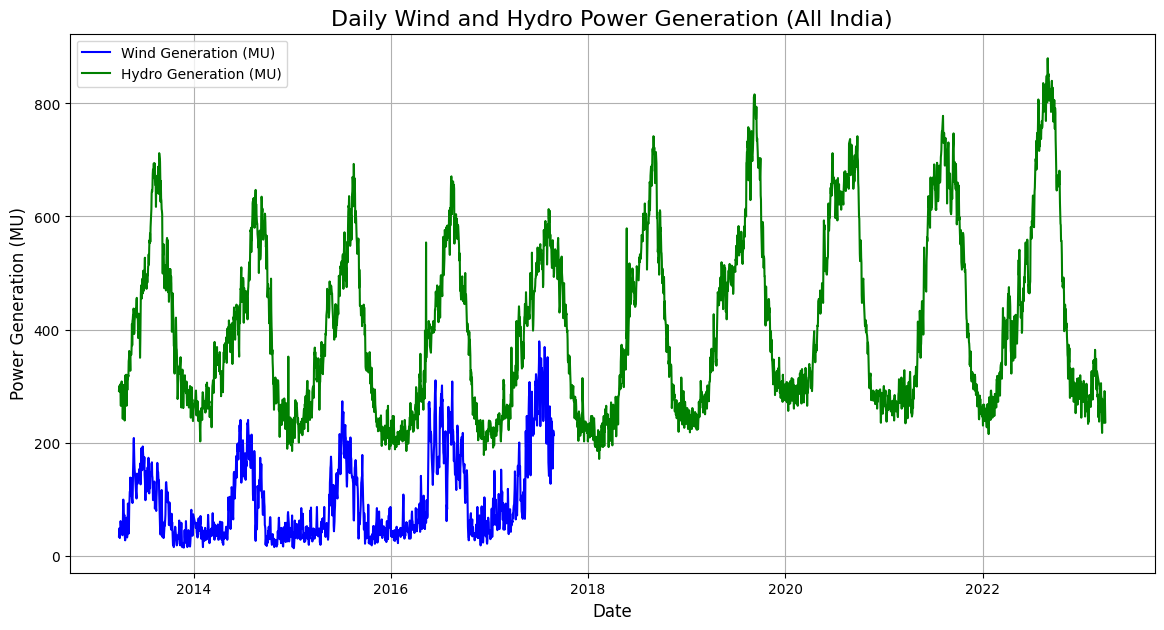

In [5]:
import matplotlib.pyplot as plt

# Filter out wind and hydropower data
wind_data = data_source[data_source['source'] == 'Wind Gen(MU)']
hydro_data = data_source[data_source['source'] == 'Hydro']

# Draw a line chart
plt.figure(figsize=(14, 7))
plt.plot(wind_data['date'], wind_data['All India'], label='Wind Generation (MU)', color='blue')
plt.plot(hydro_data['date'], hydro_data['All India'], label='Hydro Generation (MU)', color='green')
plt.title('Daily Wind and Hydro Power Generation (All India)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Power Generation (MU)', fontsize=12)
plt.legend()
plt.grid()
plt.show()

### 

C:\Users\USER\AppData\Local\Temp\ipykernel_23756\311364414.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wind_data['date'] = pd.to_datetime(wind_data['date'], errors='coerce')
C:\Users\USER\AppData\Local\Temp\ipykernel_23756\311364414.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hydro_data['date'] = pd.to_datetime(hydro_data['date'], errors='coerce')
C:\Users\USER\AppData\Local\Temp\ipykernel_23756\311364414.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

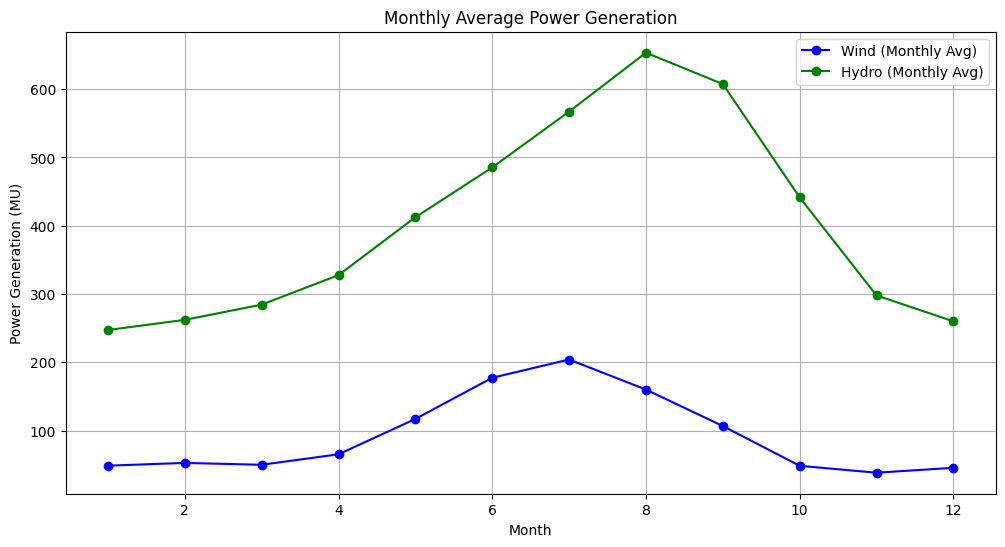

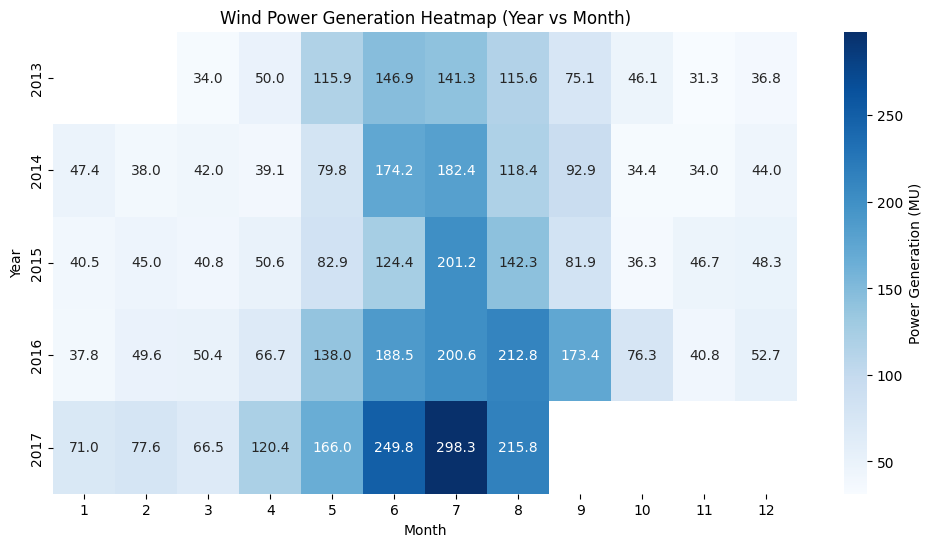

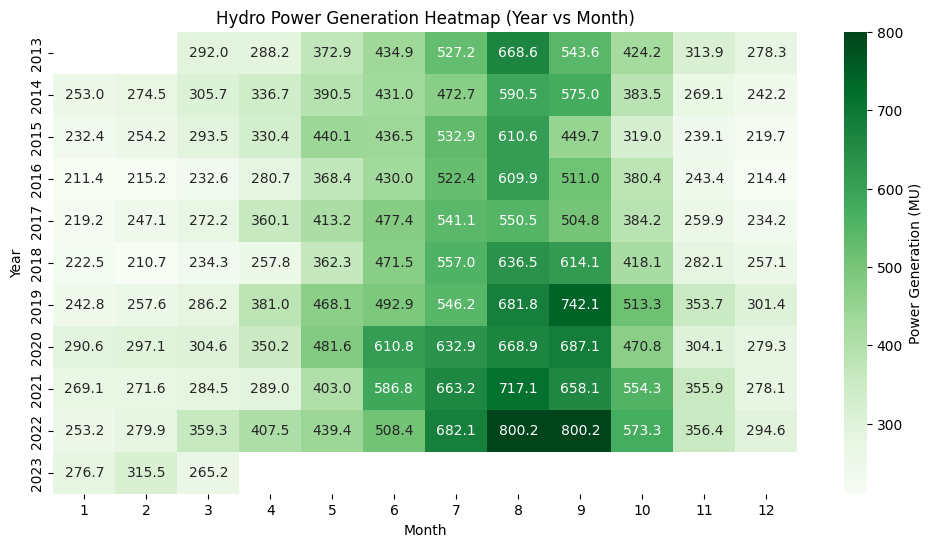

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Make sure the index is DatetimeIndex
wind_data['date'] = pd.to_datetime(wind_data['date'], errors='coerce')
hydro_data['date'] = pd.to_datetime(hydro_data['date'], errors='coerce')
wind_data.set_index('date', inplace=True)
hydro_data.set_index('date', inplace=True)

# Check and remove invalid dates
wind_data.dropna(subset=['All India'], inplace=True)
hydro_data.dropna(subset=['All India'], inplace=True)

# Make sure the 'month' field and 'year' field are accessible
wind_data['month'] = wind_data.index.month
wind_data['year'] = wind_data.index.year
hydro_data['month'] = hydro_data.index.month
hydro_data['year'] = hydro_data.index.year

# Calculate monthly average
monthly_wind = wind_data.groupby('month')['All India'].mean()
monthly_hydro = hydro_data.groupby('month')['All India'].mean()

# Draw monthly average trend chart
plt.figure(figsize=(12, 6))
plt.plot(monthly_wind, label="Wind (Monthly Avg)", color='blue', marker='o')
plt.plot(monthly_hydro, label="Hydro (Monthly Avg)", color='green', marker='o')
plt.title("Monthly Average Power Generation")
plt.xlabel("Month")
plt.ylabel("Power Generation (MU)")
plt.legend()
plt.grid()
plt.show()

# Draw a heat map of wind power generation
pivot_wind = wind_data.pivot_table(
 values='All India', index='year', columns='month', aggfunc='mean'
)

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_wind, cmap='Blues', annot=True, fmt=".1f", cbar_kws={'label': 'Power Generation (MU)'})
plt.title("Wind Power Generation Heatmap (Year vs Month)")
plt.xlabel("Month")
plt.ylabel("Year")
plt.show()

# Create heatmap for hydro power generation
pivot_hydro = hydro_data.pivot_table(
    values='All India', index='year', columns='month', aggfunc='mean'
)

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_hydro, cmap='Greens', annot=True, fmt=".1f", cbar_kws={'label': 'Power Generation (MU)'})
plt.title("Hydro Power Generation Heatmap (Year vs Month)")
plt.xlabel("Month")
plt.ylabel("Year")
plt.show()



### Proportion of wind energy and hydropower generation by region

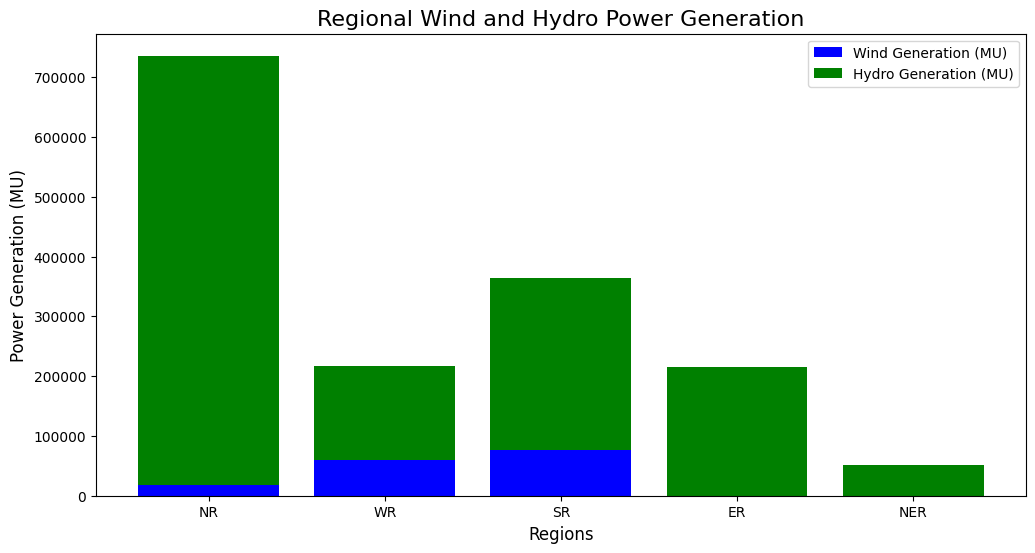

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Assume that wind_data and hydro_data are already cleaned DataFrames

# Select numerical columns for grouping and summing (exclude non-numeric columns such as 'source' and 'date')
numeric_cols = ['NR', 'WR', 'SR', 'ER', 'NER', 'All India']
wind_grouped = wind_data[numeric_cols].sum()
hydro_grouped = hydro_data[numeric_cols].sum()

# Draw stacked bar chart
labels = ['NR', 'WR', 'SR', 'ER', 'NER']
x = range(len(labels))
plt.figure(figsize=(12, 6))
plt.bar(x, wind_grouped[labels], label="Wind Generation (MU)", color='blue')
plt.bar(x, hydro_grouped[labels], bottom=wind_grouped[labels], label="Hydro Generation (MU)", color='green')
plt.xticks(ticks=x, labels=labels)
plt.title("Regional Wind and Hydro Power Generation", fontsize=16)
plt.xlabel("Regions", fontsize=12)
plt.ylabel("Power Generation (MU)", fontsize=12)
plt.legend()
plt.show()

### Analyze quarterly fluctuations

C:\Users\USER\AppData\Local\Temp\ipykernel_23756\3635275826.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wind_data['quarter'] = wind_data.index.quarter
C:\Users\USER\AppData\Local\Temp\ipykernel_23756\3635275826.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hydro_data['quarter'] = hydro_data.index.quarter


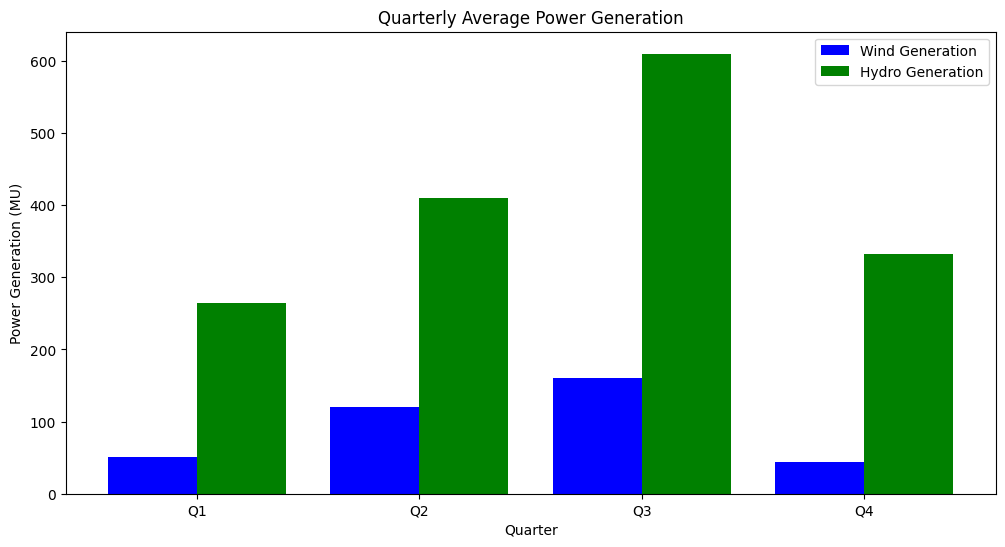

In [8]:
# Add quarterly information
wind_data['quarter'] = wind_data.index.quarter
hydro_data['quarter'] = hydro_data.index.quarter

# Calculate quarterly averages
quarterly_wind = wind_data.groupby('quarter')['All India'].mean()
quarterly_hydro = hydro_data.groupby('quarter')['All India'].mean()

# Plot quarterly trends
plt.figure(figsize=(12, 6))
plt.bar(quarterly_wind.index - 0.2, quarterly_wind, width=0.4, label='Wind Generation', color='blue')
plt.bar(quarterly_hydro.index + 0.2, quarterly_hydro, width=0.4, label='Hydro Generation', color='green')
plt.title("Quarterly Average Power Generation")
plt.xlabel("Quarter")
plt.ylabel("Power Generation (MU)")
plt.xticks(ticks=[1, 2, 3, 4], labels=['Q1', 'Q2', 'Q3', 'Q4'])
plt.legend()
plt.show()


### LSTM Model

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import geopandas as gpd

# Load and Clean Data
source_data = pd.read_csv("cleaned_Daily_Power_Gen_Source.csv")
state_data = pd.read_csv("cleaned_Daily_Power_Gen_States.csv")

# Convert date columns to datetime
source_data['date'] = pd.to_datetime(source_data['date'], errors='coerce')
state_data['date'] = pd.to_datetime(state_data['date'], errors='coerce')

# Filter relevant columns for wind and hydro generation
wind_data = source_data[source_data['source'] == 'Wind Gen(MU)']
hydro_data = source_data[source_data['source'] == 'Hydro']

# Reset indices for wind and hydro datasets
wind_data = wind_data.reset_index(drop=True)
hydro_data = hydro_data.reset_index(drop=True)

# Fill missing values with median
wind_data['All India'] = wind_data['All India'].fillna(wind_data['All India'].median())
hydro_data['All India'] = hydro_data['All India'].fillna(hydro_data['All India'].median())



In [ ]:
# Combine Geographic Data

# Load shapefile and filter for India
shapefile_path = "ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp"
world = gpd.read_file(shapefile_path)
india = world[world['NAME'] == 'India']

# Prepare state names for merging
state_data.rename(columns={'States': 'State'}, inplace=True)
state_data['State'] = state_data['State'].str.strip().str.title()
india['NAME'] = india['NAME'].str.strip().str.title()

# Merge shapefile and state data
merged_data = india.merge(state_data, left_on='NAME', right_on='State', how='left')

# Check for unmatched states
unmatched_states = state_data[~state_data['State'].isin(merged_data['NAME'])]
if not unmatched_states.empty:
    print("Unmatched states:")
    print(unmatched_states)



Unmatched states:
       Region              State  Max.Demand Met during the day(MW)  \
0         NER            Mizoram                                 77   
1          WR                 Dd                                214   
2          WR                Goa                                383   
3          WR        Maharashtra                              14837   
4          WR                 Mp                               5740   
...       ...                ...                                ...   
126694     SR             Kerala                               3844   
126695     SR          Karnataka                              13135   
126696     SR          Telangana                              13723   
126697    NER            Tripura                                226   
126698    NER  Arunachal Pradesh                                141   

        Shortage during maximum Demand(MW)  Energy Met (MU)       date  
0                                      1.0              

c:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
# Prepare Data for LSTM

# Normalize 'All India' values for LSTM input
scaler_wind = MinMaxScaler()
scaler_hydro = MinMaxScaler()

wind_values = scaler_wind.fit_transform(wind_data['All India'].values.reshape(-1, 1)).flatten()
hydro_values = scaler_hydro.fit_transform(hydro_data['All India'].values.reshape(-1, 1)).flatten()

# Function to create lag features for multi-step prediction
def create_lag_features(data, lag=10):
    X, y = [], []
    for i in range(lag, len(data) - 60):
        X.append(data[i-lag:i])
        y.append(data[i:i+60])
    return np.array(X), np.array(y)

# Create lag features for wind and hydro data
X_wind, y_wind = create_lag_features(wind_values, lag=10)
X_hydro, y_hydro = create_lag_features(hydro_values, lag=10)

# Split data into training and testing sets
X_wind_train, X_wind_test, y_wind_train, y_wind_test = train_test_split(X_wind, y_wind, test_size=0.2, random_state=42)
X_hydro_train, X_hydro_test, y_hydro_train, y_hydro_test = train_test_split(X_hydro, y_hydro, test_size=0.2, random_state=42)

# Reshape inputs for LSTM
X_wind_train = X_wind_train.reshape((X_wind_train.shape[0], X_wind_train.shape[1], 1))
X_wind_test = X_wind_test.reshape((X_wind_test.shape[0], X_wind_test.shape[1], 1))

X_hydro_train = X_hydro_train.reshape((X_hydro_train.shape[0], X_hydro_train.shape[1], 1))
X_hydro_test = X_hydro_test.reshape((X_hydro_test.shape[0], X_hydro_test.shape[1], 1))


In [ ]:
# Add time features
wind_data['month'] = wind_data['date'].dt.month
hydro_data['month'] = hydro_data['date'].dt.month

# Use pandas.get_dummies for OneHot encoding
geo_features = pd.get_dummies(state_data['States'], prefix="state")

In [ ]:
# Build and Train LSTM Model

# Enhanced LSTM Model with additional regularization and optimizer
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(256, activation='tanh', return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(LSTM(128, activation='tanh', return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(64, activation='tanh'))
    model.add(Dropout(0.3))
    model.add(Dense(60))  # forcast for next 60 days
    model.compile(optimizer='adam', loss='mse')  # Using the Adam optimizer
    return model

# Build and train enhanced wind model
wind_model = build_lstm_model((10, 1))
wind_model.fit(X_wind_train, y_wind_train, epochs=300, batch_size=32, verbose=1)

# Build and train enhanced hydro model
hydro_model = build_lstm_model((10, 1))
hydro_model.fit(X_hydro_train, y_hydro_train, epochs=300, batch_size=32, verbose=1)



Epoch 1/300


c:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0618
Epoch 2/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0322
Epoch 3/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0305
Epoch 4/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0282
Epoch 5/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0292
Epoch 6/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0266
Epoch 7/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0266
Epoch 8/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0257
Epoch 9/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0260
Epoch 10/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0264
Epoch 11/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0248
Epoch 12/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0239
Epoch 13/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0257
Epoch 14/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0265
Epoch 15/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0238
E

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


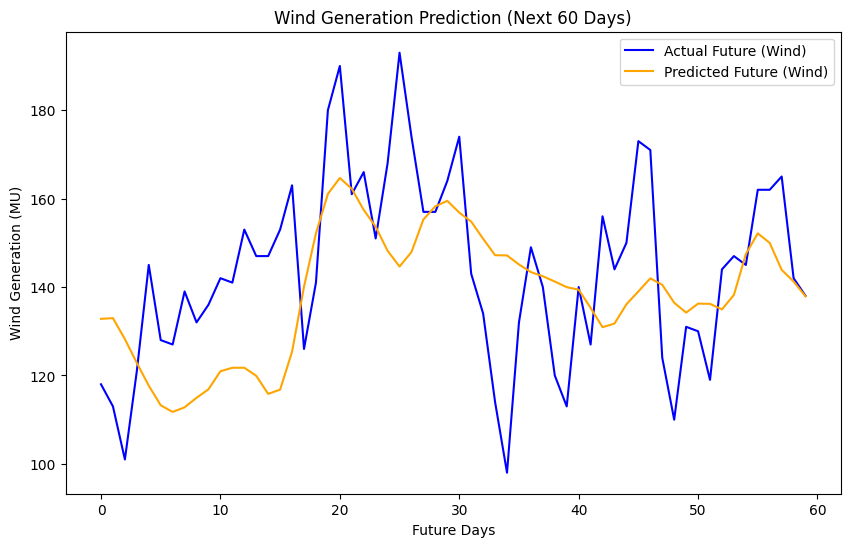

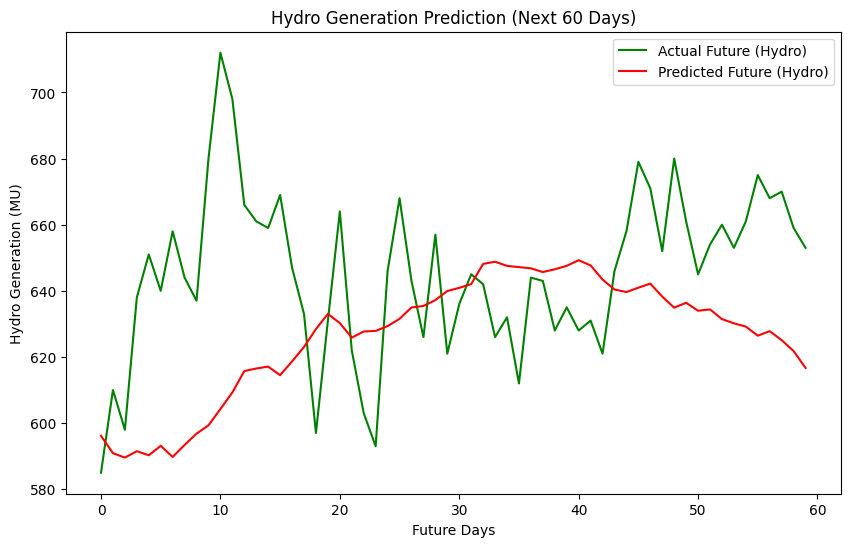

In [ ]:
# Evaluate and Visualize Predictions

# Predict and inverse transform predictions
y_wind_pred = wind_model.predict(X_wind_test)
y_hydro_pred = hydro_model.predict(X_hydro_test)

y_wind_test_inverse = scaler_wind.inverse_transform(y_wind_test.reshape(-1, 1)).reshape(y_wind_test.shape)
y_wind_pred_inverse = scaler_wind.inverse_transform(y_wind_pred.reshape(-1, 1)).reshape(y_wind_pred.shape)

y_hydro_test_inverse = scaler_hydro.inverse_transform(y_hydro_test.reshape(-1, 1)).reshape(y_hydro_test.shape)
y_hydro_pred_inverse = scaler_hydro.inverse_transform(y_hydro_pred.reshape(-1, 1)).reshape(y_hydro_pred.shape)

# Visualize predictions for wind
plt.figure(figsize=(10, 6))
plt.plot(range(60), y_wind_test_inverse[0], label='Actual Future (Wind)', color='blue')
plt.plot(range(60), y_wind_pred_inverse[0], label='Predicted Future (Wind)', color='orange')
plt.title("Wind Generation Prediction (Next 60 Days)")
plt.xlabel("Future Days")
plt.ylabel("Wind Generation (MU)")
plt.legend()
plt.show()

# Visualize predictions for hydro
plt.figure(figsize=(10, 6))
plt.plot(range(60), y_hydro_test_inverse[0], label='Actual Future (Hydro)', color='green')
plt.plot(range(60), y_hydro_pred_inverse[0], label='Predicted Future (Hydro)', color='red')
plt.title("Hydro Generation Prediction (Next 60 Days)")
plt.xlabel("Future Days")
plt.ylabel("Hydro Generation (MU)")
plt.legend()
plt.show()


# Evaluation

In [62]:
from sklearn.metrics import r2_score

# Function to evaluate the model
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - MSE: {mse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")
    return mse, mae, r2

# Evaluate wind model
mse_wind, mae_wind, r2_wind = evaluate_model(y_wind_test_inverse[0], y_wind_pred_inverse[0], "Wind Model")

# Evaluate hydro model
mse_hydro, mae_hydro, r2_hydro = evaluate_model(y_hydro_test_inverse[0], y_hydro_pred_inverse[0], "Hydro Model")


Wind Model - MSE: 430.02, MAE: 17.09, R²: 0.01
Hydro Model - MSE: 1348.02, MAE: 29.63, R²: -1.21
